In [12]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from IPython.display import Image


In [13]:
def deleteId(ds):
    return ds.drop(columns='Id')

def deleteNaN(train_ds, test_ds, critval):
    fullsize = train_ds.shape[0]
    new_train = train_ds.copy()
    new_test = test_ds.copy()
    for feature in new_train.columns:
        nulls = new_train[feature].isnull().sum()
        percent = nulls / fullsize
        if (percent > critval):
            new_train = new_train.drop(columns=feature)
            new_test = new_test.drop(columns=feature)
    return new_train, new_test

def convertToNumeric(train_ds, test_ds):
    new_train = train_ds.copy()
    new_test = test_ds.copy()
    LE = LabelEncoder()
    for feature in new_train.columns[:-1]:
        if (new_train[feature].dtype == 'object'):
            new_train[feature] = LE.fit_transform(new_train[feature])
            new_test[feature] = LE.fit_transform(new_test[feature])
    return new_train, new_test

def check_error(preds, gt):
    print('RMSE Error:', mean_squared_error(np.log(preds), np.log(gt), squared=False))

In [14]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train = train.drop_duplicates()

train = deleteId(train)  
train, test = deleteNaN(train, test ,critval=0.7)
train, test = convertToNumeric(train, test)

y_train = train['SalePrice'].values
x_train = train.drop(columns='SalePrice').values
x_super_test = test.values

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=98987)

imp = SimpleImputer(strategy='mean')
X_train = imp.fit_transform(X_train)
X_test = imp.fit_transform(X_test)

### PCA + Scaler


In [15]:
pca = PCA(n_components = 20)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

### Random Forest

In [16]:
parameters = {
    'criterion':(['squared_error']), 
    'max_depth': (1000, 1500, 2000, None),
    
    'n_estimators':(5, 10, 20, 50),
    'min_samples_split':(2, 5, 9)}

model = RandomForestRegressor()
gs_model = GridSearchCV(model, parameters)
gs_model.fit(X_train[:300], y_train[:300])
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'criterion': 'squared_error', 'max_depth': 2000, 'min_samples_split': 5, 'n_estimators': 20}


In [17]:
model = RandomForestRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
check_error(model.predict(X_test), y_test)

RMSE Error: 0.20615016361533628


### XGBoost

### Loss functions
Regression loss functions
$L(y,f) = (y -f)^2$

$L(y, f) = |y -f|$


Classification loss functions
$L(y, f) = \log{1 + \exp(-2yf)}$ - logistic

$L(y, f) = \exp{-yf}$ -ada boost


### GBM Algorithm
1. Initialize GBM with constant value $\hat{f(x)} = \hat{f_0}$,

$\hat{f_0} = argmin \sum_{i=1}^{n}{L(y_i,\gamma)}$

2. For each iteration t = 1..M

3. Calculate $r_{it} = -\frac{\partial{L(y_i, f(x_i))}}{\partial{f(x_i)}}$

4. Build new base algorithm $h_t(x)$  as regression on pseudo-residuals ${(x_i, r_{it})}$ 

5. Find optimal coefficient $\rho_t$  at $h_t(x)$  regarding initial loss function

$\rho_t = argmin \sum_{i=1}^{n}{L(y_i, \hat{f(x_i)} + \rho \cdot h(x_i, \theta))}$

6. $\hat{f}_t(x) = \rho_t \cdot h_t(x)$


7. Update approximation $\hat{f}(x) <- \sum_{i = 0}^{t}{f_i(x)}$

8. $\hat{f}(x) = \sum_{i = 0}^{M}{f_i(x)}$


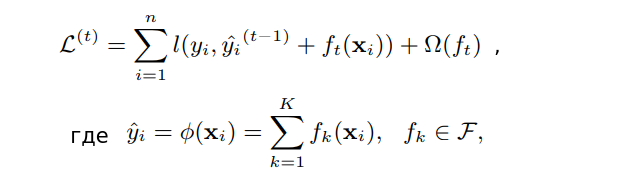

In [18]:
Image("images/xgb_1.png")

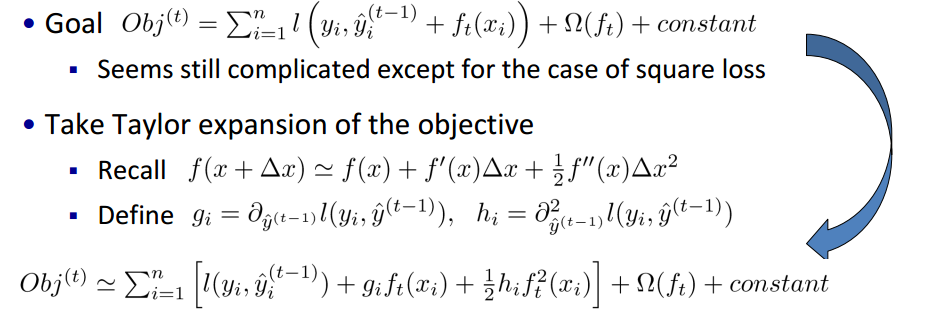

In [19]:
Image("images/xgb_taylor.png")

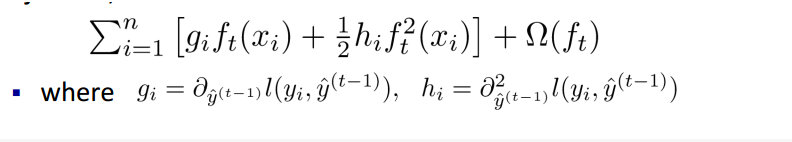

In [20]:
Image("images/xgboost_empirical.png")

$\Omega (f_t) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2$

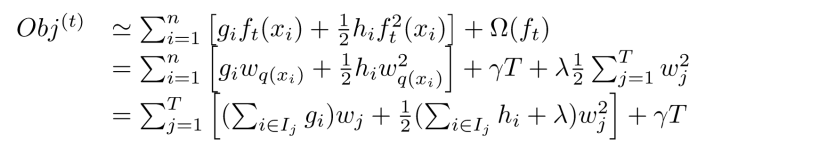

In [21]:
Image("images/xgb_leafs_regroup.png")

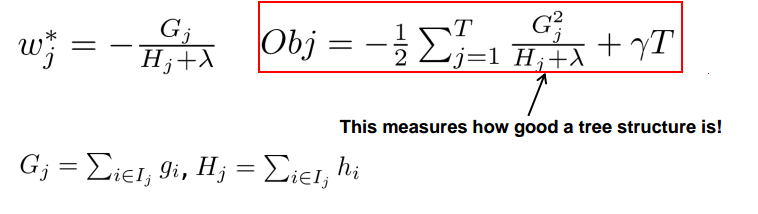

In [22]:
Image("images/xgb_tree_quality.png")

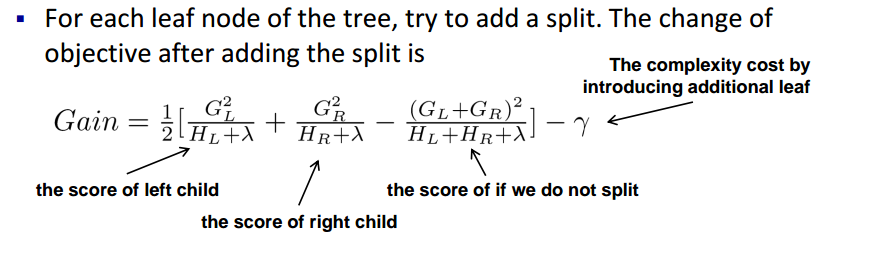

In [23]:
Image("images/xgb_tree_split_criteria.png")

In [24]:
parameters = {
    "learning_rate": (0.05, 0.1, 0.15),
    "max_depth": [4, 5, 6],
    "min_child_weight": [7, 9, 12],
    "n_estimators":(30,50, 70)}

model = XGBRegressor()
gs_model = GridSearchCV(model, parameters)
gs_model.fit(X_train[:300], y_train[:300])
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 12, 'n_estimators': 70}


In [25]:
model = XGBRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
check_error(model.predict(X_test), y_test)

RMSE Error: 0.2029348814603594


### LightGBM



В отличие от поуровневого (горизонтального) роста в XGBoost, LightGBM выполняет листовой (вертикальный) рост, что приводит к большему снижению потерь и, в свою очередь, к более высокой точности при более высокой скорости. 

In [26]:
model = LGBMRegressor()

parameters = {
    'num_leaves': [i for i in range(3,15,2)],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100],}

gs_model = GridSearchCV(model, parameters)
gs_model.fit(X_train[:300], y_train[:300])
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50, 'num_leaves': 11}


In [27]:
model = LGBMRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
check_error(model.predict(X_test), y_test)

RMSE Error: 0.24040962990936537


In [28]:
def getCategorialFeatures(train_ds):
    cat_features = []
    iter = 0
    for feature in train_ds.columns[:-1]:
        if (train_ds[feature].dtype == 'object'):
            cat_features.append(iter)
        iter +=1 
    return cat_features

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train = train.drop_duplicates()

train = deleteId(train)  
train, test = deleteNaN(train, test ,critval=0.7)
cat_features = getCategorialFeatures(train)

y_train = train['SalePrice'].values
x_train = train.drop(columns='SalePrice').values
x_super_test = test.values

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=98987)

imp = SimpleImputer(strategy='most_frequent')
X_train = imp.fit_transform(X_train)
X_test = imp.fit_transform(X_test)

# Cat Boost
1) В качестве базового алгоритма используются небрежные решающие деревья (ODT - Obvious Decision Tree)
2) В качестве метода ансаблированния используется модифицированный градиентный бустинг. Суть его следующая:
   * Перед обучением создаётся s перестановок обучающей выборки $X_1, X_2, ..., X_s$. 
   * Кадая из этих перестановок $X_\sigma$ делится на части, длина которых возрастает в геометрической прогрессии ($2^i$). 
   * Каждый новый алгоритм ансамбля $b_t$ строится на перстановке $X_\sigma$, где $\sigma$ выбирается случайным образом от 0 до s
   * $$b_t := \arg\min_b\sum_{i=1}^{l}{(b(x_i) + g_{ti})^2}$$
   * Градиент $g_{ti}$ вычисляется по выборке $X^{\sigma j}$, где j - это подвыборка перстановки в которой не учасвствовал объект $x_i$
   * $$g_{t i} = \mathcal{L}'(a^{r j}_{t-1}(x_i), y_i) $$
   * $$j = \log_2(i - 1)$$
3) Следующая фича - работа с категориальными признаками. Категориальные признаки преобразуются в вещественные с помощью метода статистики по целевому признаку (TS).


In [29]:
model = CatBoostRegressor(loss_function='RMSE', cat_features=cat_features)
model.fit(X_train, y_train, plot=True)
check_error(model.predict(X_test), y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.042748
0:	learn: 76930.4091113	total: 55.6ms	remaining: 55.5s
1:	learn: 74859.8884342	total: 61.6ms	remaining: 30.7s
2:	learn: 73006.7045395	total: 68.2ms	remaining: 22.7s
3:	learn: 71005.1089006	total: 75.5ms	remaining: 18.8s
4:	learn: 69301.2682476	total: 81.2ms	remaining: 16.2s
5:	learn: 67572.8459105	total: 88.5ms	remaining: 14.7s
6:	learn: 65919.7517106	total: 96.1ms	remaining: 13.6s
7:	learn: 64315.7210541	total: 102ms	remaining: 12.7s
8:	learn: 62720.0306505	total: 109ms	remaining: 12s
9:	learn: 61306.0702768	total: 115ms	remaining: 11.4s
10:	learn: 59899.0116968	total: 121ms	remaining: 10.9s
11:	learn: 58540.3382105	total: 132ms	remaining: 10.8s
12:	learn: 57218.6861287	total: 138ms	remaining: 10.5s
13:	learn: 55974.9360650	total: 146ms	remaining: 10.3s
14:	learn: 54755.6045223	total: 152ms	remaining: 10s
15:	learn: 53554.8727241	total: 158ms	remaining: 9.74s
16:	learn: 52401.9591590	total: 165ms	remaining: 9.54s
17:	learn: 51280.5153216	total: 170ms	rema